In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown
import scipy.optimize as opt

# 3. Fitting Circles

2431 points


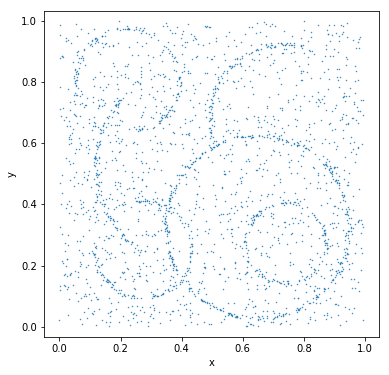

In [2]:
data = np.load('circles.npy')
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=0.2)
ax.axis('equal')
ax.set_xlabel('x'); ax.set_ylabel('y')
print(f"{data.shape[0]} points")

As a human I would fit 6 circles/circle segments to this data

## 3.1 RANSAC

For the RANSAC algorithm we need to find center and radius of a circle from 3 points. We can transform the circle equation to a system of linear equations:

$$ (x_i - x_c)^2 + (y_i -y_c)^2 = R^2 \quad \text{for } i \in \{1,2,3\} \text{ and } x_c,y_c \text{ center coordinates}$$

$$ \Rightarrow x_i^2 - 2x_i x_c + x_c^2 + y_i^2 - 2y_i y_c + y_c^2 = R$$

$$ \Rightarrow x_1^2 - 2x_1 x_c + y_1^2 - 2y_1 y_c = x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c = x_3^2 - 2x_i x_c + y_3^2 - 2y_3 y_c$$

Now create linear system from first half of this equation:

$$x_1^2 - 2x_1 x_c + y_1^2 - 2y_1 y_c = x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c$$

$$ \Rightarrow 2(x_1-x_2)x_c + 2(y_1-y_2)y_c = x_1^2 + y_1^2 - x_2^2 - y_2^2 $$

And the same from the right hand side:

$$x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c = x_3^2 - 2x_3 x_c + y_3^2 - 2y_3 y_c$$

$$ \Rightarrow 2(x_2-x_3)x_c + 2(y_2-y_3)y_c = x_2^2 + y_2^2 - x_3^2 - y_3^2 ​$$

From these two results we can create the linear system:

$$ \begin{pmatrix} 2(x_1-x_2) & 2(y_1-y_2)  \\ 2(x_2-x_3) & 2(y_2-y_3) \end{pmatrix} \begin{pmatrix} x_c \\ y_c \end{pmatrix} = \begin{pmatrix} x_1^2 + y_1^2 - x_2^2 - y_2^2 \\ x_2^2 + y_2^2 - x_3^2 - y_3^2 \end{pmatrix} $$

We can just solve this system easily and get the center coordinates. If the matrix is not regular, there is no unique solution, and the RANSAC step is just ignored.

To get the radius from the center coordinates using the circle equation and one of the three points:

$$ R = \sqrt{(x_i - x_c)^2 + (y_i -y_c)^2} $$

In [3]:
def circle_3point(p):
    "Fit circle to 3 points"
    # create linear system
    A = np.array([[2 * (p[0,0]-p[1,0]), 2*(p[0,1]-p[1,1])],
                  [2 * (p[1,0]-p[2,0]), 2*(p[1,1]-p[2,1])]])
    b = np.array([p[0,0]**2 + p[0,1]**2 - p[1,0]**2 - p[1,1]**2,
                  p[1,0]**2 + p[1,1]**2 - p[2,0]**2 - p[2,1]**2])
    # solve linear system
    center = np.linalg.solve(A, b)
    R = np.linalg.norm(p[0] - center)
    return center, R

In [4]:
def ransac_single(data, eps, N=10000):
    center_best, r_best = np.zeros(2), 0
    inlier_count_best = 0
    eps2 = eps**2
    for _ in range(N):
        # select 3 random points and fit circle to it
        p_ind = np.random.randint(data.shape[0], size=3)
        try:
            center, r = circle_3point(data[p_ind])
        except np.linalg.LinAlgError:
            # if no unique solution for circle, ignore step
            continue
        # find inliers of circle: R - eps < ||p - center|| < R + eps
        dist2 = (data[:,0] - center[0])**2 + (data[:,1] - center[1])**2
        inliers = abs(dist2 - r**2) < eps2
        inlier_count = np.count_nonzero(inliers)
        # save circle and inlier if best up to this point
        if inlier_count > inlier_count_best:
            center_best, r_best = center, r
            inliers_best = inliers
            inlier_count_best = inlier_count
    # if no circle was found, return None
    if r_best == 0:
        return None, None, None
    else:
        return center_best, r_best, inliers_best

In [5]:
def ransac_multi(data, N_circles, eps, N_ransac=10000,  fit_circle=None):
    """
    Function to find multiple circles using RANSAC
    Input:
    data: data points in array N_points x 2
    N_circles (int): #circles which should be fittet
    N_ransac (int): #iterations for RANSAC
    eps (float): maximal deviation for RANSAC
    fit_circle(data, inlier, center,radius) (function): function to fit circle to
        inliers found with RANSAC
        Default: Use center,radius from RANSAC, otherwise these parameters can be ignored        
    """
    if fit_circle is None:
        fit_circle =lambda d, i, c, r : (c, r)
    circles = []
    inlier_all = np.zeros(data.shape[0], dtype=bool)
    for _ in range(N_circles):
        # find new circle with remaining data
        center, r, inlier = ransac_single(data, eps=eps, N=N_ransac)
        # if RANSAC doesn't find circle, return
        if r is None:
            break
        # fit circle to inliers
        # if fit_circles not explicitly given, use r, center from 3 points in RANSAC
        circles.append(fit_circle(data, inlier, center, r))
        # keep track of all inliers
        inlier_all[~inlier_all] = inlier
        # remove inliers from dataset for next step
        data = data[~inlier]
        # return if no data is left
        if data.shape[0] == 0:
            break
    return circles, inlier_all

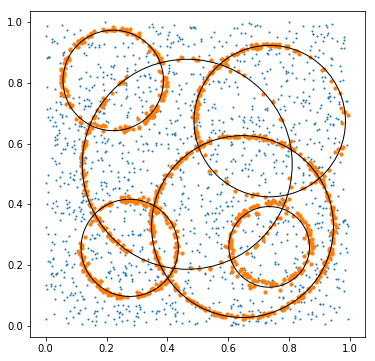

In [6]:
def ransac_plot(data, circles, inlier, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(data[:,0], data[:,1], s=1, label='All data')
    ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
    for center, r in circles:
        ax.add_patch(plt.Circle(center, r, fill=False))
    ax.axis('equal');
ransac_plot(data, *ransac_multi(data, 6, eps=0.07))

If we can see, if we find the right parameters for eps and N_circles, the results look really good. But if we increase N_circle, the algorithm finds as many circles as we want (if there are data points left), and most of them are not obvious as a human:

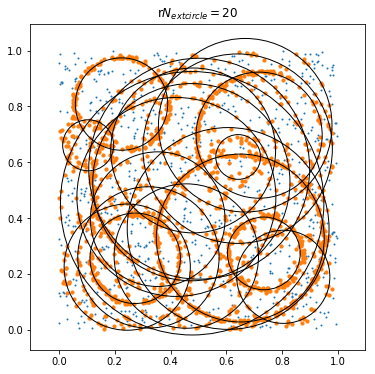

In [7]:
ransac_plot(data, *ransac_multi(data, 20, eps=0.07))
plt.title("r$N_{\text{circle}}=20$");

To fix that, we would need to define a minimum of inliers (as ratio to datapoints), such that only circles with enough data points are fitted.
eps also has a big impact on the result:

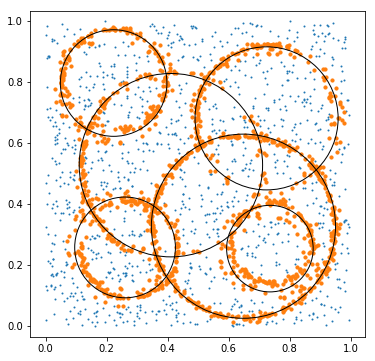

In [8]:
ransac_plot(data, *ransac_multi(data, 6, eps=0.1))

We now have much more inlier, and the circle structures are not quite clear.
To get consistent results over multiple tries with RANSAC, the number of iterations has to be big enough, otherwise there are different circles every time.

In conclusion: eps has to be tuned precisely to find good circles, and it would be useful to define a minimum of inliers for circle to be fitted.

## 3.2 Algebraic Distance

To get a better circle fit to the inliers found with RANSAC we minimize the algebraic distance: (inlier $x_i$, center coordinates $c$, radius $r$)

$$
\hat c, \hat r = \underset{c, r}{\operatorname{argmin}} \sum_i (\|x_i - c \|^2-r^2)^2  = \underset{c, r}{\operatorname{argmin}} \sum_i ((x_i - c )^T(x_i - c )-r^2)^2 = \underset{c, r}{\operatorname{argmin}} \sum_i (x_i^T x_i - 2c^T x_i + c^T c - r^2)^2
$$

Now we move to augmented space and define $\tilde x$, $\tilde{y}$ and $\beta$:

$$ \tilde{x}  = \begin{pmatrix} x_{i1} & x_{i2} &  1 \end{pmatrix} $$

$$ \tilde{y} = x_i^T x_i $$

$$\beta = \begin{pmatrix} 2c_1 \\ 2c_2 \\ r^2-c^T c \end{pmatrix}$$
$$
\Rightarrow \tilde{x} \cdot \beta = 2x_{i1}c_1 + 2x_{i2}c_2 + r^2 - c^T c = 2 c^T x_i - c^T c + r^2
$$
With these definitions we can now minimize
$$
\hat{\beta} = \underset{\beta}{\operatorname{argmin}} \sum_i (\tilde{y} -\tilde{x}_i \beta)^2
$$
using the least-squares method. From $\hat{\beta}$ we get our circle parameters back easily with $c_1 = \hat{\beta}_1$, $c_2 = \hat{\beta}_2 $ , $ r = \sqrt{\hat{\beta}_3 + c^T c}$

In [9]:
def algebraic_distance(data, inlier, c=None,r=None):
    # ggo to augmented space
    data = data[inlier]
    x = np.hstack((data, np.ones((data.shape[0],1))))
    y = np.sum(np.square(data), axis=1)
    beta = np.linalg.lstsq(x, y)[0]
    center = beta[:2] / 2
    r = np.sqrt(beta[2] + np.sum(np.square(center)))
    return center, r

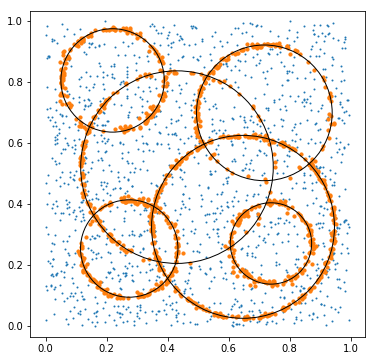

In [10]:
ransac_plot(data, *ransac_multi(data, 6, eps=0.07, fit_circle=algebraic_distance))

As we can see here, the fitted circles are much better fitted to their inliers, it is most obvious with the small circle on the bottom right.
If we make eps a bit bigger, we can now see that the fit is much better that the RANSAC fit.

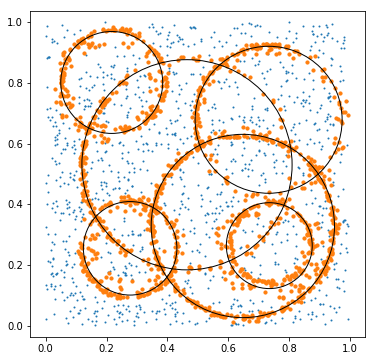

In [11]:
ransac_plot(data, *ransac_multi(data, 6, eps=0.1, fit_circle=algebraic_distance))

## 3.3 Levenberg-Marquardt

To fit the a circle to a set of inliers $X$, we use:
$$
\underset{c,r}{\operatorname{min}} \sum_i (\|X_i - c \|_2 - r)^2 = \underset{c,r}{\operatorname{min}} \sum_i (d_i - r)^2
\quad \text{with } d_i = \|X_i - c \|_2 = \sqrt{(c_1 - X_{i1})^2 + (c_2 - X_{i2})^2}
$$
We now find the optimal value $\hat r$ dependent on $c$:
$$
\partial_r \sum_i (d_i - r)^2 |_{r =\hat r} \overset{!}{=} 0 = \sum_i 2(d_i - \hat r) \\
\Rightarrow \hat r = \frac{\sum_i d_i}{N} = \operatorname{mean}(d_i) \qquad \text{with } N \text{: #Points}
$$
Now define function $f$ for Levenberg-Marquant algorithm:
$$
f_i(X, c) = d_i - \hat r = d_i - \frac{\sum_k d_k}{N}
$$
And the Jacobi-matrix $J_{ij} = \frac{\partial f_i(X,c)}{\partial c_j}$ for that function:
$$ J_i =
\begin{pmatrix}
\frac{c_1 - X_{i1}}{d_i} - \frac{1}{N} \sum_k \frac{c_1 - X_{k1}}{d_k},  &
\frac{c_2 - X_{i2}}{d_i} - \frac{1}{N} \sum_k \frac{c_2 - X_{k2}}{d_k}
\end{pmatrix}
$$
$J$ is a Nx2 matrix. Now we use the Scipy function scipy.optimize.root(method='lm') to solve for the optimal $\hat c$, and can calculate $\hat r$ from that.

In [12]:
def levenberg_func(center, data):
    # calculate norm
    d = np.linalg.norm(data - center, axis=1)
    r = np.mean(d)
    # function value
    f = d - r
    # Jacobi matrix
    df = np.array([(center[0]-data[:,0])/d - np.mean((center[0]-data[:,0])/d),
                   (center[1]-data[:,1])/d - np.mean((center[1]-data[:,1])/d)]).T
    return f, df
def levenberg_fitter(data, inlier, center, r=None):
    sol = opt.root(levenberg_func, center, args=(data[inlier]), method='lm', jac=True)
    center = sol.x
    r = np.mean(np.linalg.norm(data[inlier] - center, axis=1))
    return center, r

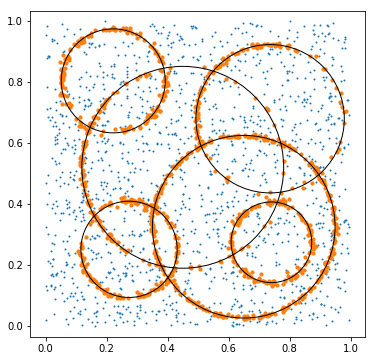

In [13]:
ransac_plot(data, *ransac_multi(data, 6, eps=0.07, fit_circle=levenberg_fitter))

In this case we cannot see many differences between the algebraic solution and the solution via the Levenberg-Marquardt algorithm, but if we increase eps again, we now see a clear difference

Text(0.5,1,'Algebraic Distance')

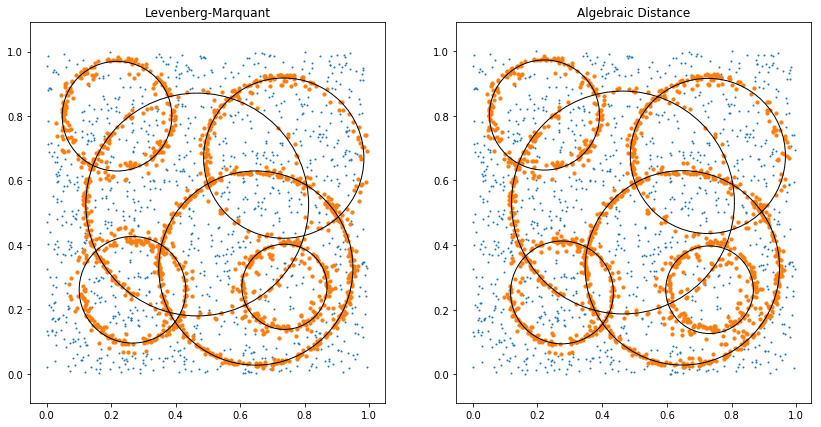

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14,7))
ransac_plot(data, *ransac_multi(data, 6, eps=0.1, fit_circle=levenberg_fitter), axes[0])
axes[0].set_title('Levenberg-Marquant')
ransac_plot(data, *ransac_multi(data, 6, eps=0.1, fit_circle=algebraic_distance), axes[1])
axes[1].set_title('Algebraic Distance')

## 3.4 Comparison

In [15]:
center, r, inlier = ransac_single(data, eps=0.1)
# select 20 random points and make them inlier
rd_inlier = np.random.randint(inlier.shape[0], size=20)
inlier[rd_inlier] = True

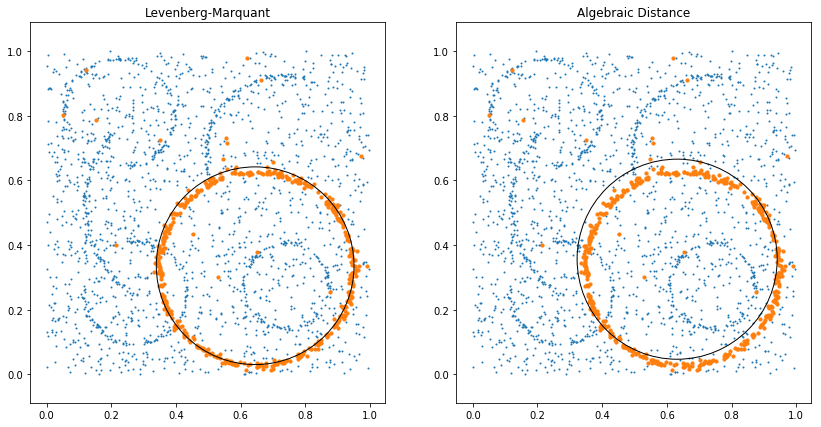

In [16]:
fig, axes = plt.subplots(1,2, figsize=(14,7))
ransac_plot(data, [levenberg_fitter(data, inlier, center)], inlier, axes[0])
axes[0].set_title('Levenberg-Marquant')
ransac_plot(data, [algebraic_distance(data, inlier, center)], inlier, axes[1])
axes[1].set_title('Algebraic Distance');

To show that the LM method is more robust to outliers, we selected a circle with RANSAC and added 20 random inlier to the set, and then used LM and algebraic distance to fit a circle. As we can see, the circle from the LM method is much closer to the circle found with RANSAC, while the circle from algebraic distance is way worse.